In [ ]:
#@title **Drive mount** { display-mode: "form" }
import os
from google.colab import drive

path_ai = "IA1" #@param {type:"string"}
path = "/content/drive/My Drive/" + path_ai
drive.mount('/content/drive')
os.chdir(path)
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/IA1


In [ ]:
#@title Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#@title Cargar datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *

df = pd.read_csv("lung_cancer_prediction_dataset.csv")
print(df.shape)
display(df.head())

(220632, 24)


,ID,Country,Population_Size,Age,Gender,Smoker,Years_of_Smoking,Cigarettes_per_Day,Passive_Smoker,Family_History,...,Air_Pollution_Exposure,Occupational_Exposure,Indoor_Pollution,Healthcare_Access,Early_Detection,Treatment_Type,Developed_or_Developing,Annual_Lung_Cancer_Deaths,Lung_Cancer_Prevalence_Rate,Mortality_Rate
0,0,China,1400,80,Male,Yes,30,29,No,No,...,Low,Yes,No,Poor,No,NaN,Developing,690000,2.44,0.0
1,1,Iran,84,53,Male,No,0,0,Yes,No,...,Low,Yes,No,Poor,No,NaN,Developing,27000,2.10,0.0
2,2,Mexico,128,47,Male,Yes,12,6,Yes,No,...,Medium,No,No,Poor,Yes,NaN,Developing,28000,1.11,0.0
3,3,Indonesia,273,39,Female,No,0,0,No,Yes,...,Low,No,No,Poor,No,NaN,Developing,40000,0.75,0.0
4,4,South Africa,59,44,Female,No,0,0,Yes,No,...,Medium,Yes,No,Poor,No,NaN,Developing,15000,2.44,0.0


In [ ]:
#@title Elimnación de columnas y encoding strings to integers
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv("lung_cancer_prediction_dataset.csv")
cols_to_drop = [
    "ID",
    "Population_Size",
    "Cancer_Stage",
    "Survival_Years",
    "Adenocarcinoma_Type",
    "Early_Detection",
    "Treatment_Type",
    "Developed_or_Developing",
    "Annual_Lung_Cancer_Deaths",
    "Lung_Cancer_Prevalence_Rate",
    "Mortality_Rate"
]

df = df.drop(columns=cols_to_drop)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Guardar encoder para posible uso futuro (ej. inverso)

target_col = "Lung_Cancer_Diagnosis"
if df[target_col].dtype != 'int64' and df[target_col].dtype != 'float64':
    le_target = LabelEncoder()
    df[target_col] = le_target.fit_transform(df[target_col])
    label_encoders[target_col] = le_target

print(f"Dataset procesado con {df.shape[0]} filas y {df.shape[1]} columnas.")
print("Variables categóricas codificadas:", cat_cols)
print(df.columns)

Dataset procesado con 220632 filas y 13 columnas.
Variables categóricas codificadas: ['Country', 'Gender', 'Smoker', 'Passive_Smoker', 'Family_History', 'Lung_Cancer_Diagnosis', 'Air_Pollution_Exposure', 'Occupational_Exposure', 'Indoor_Pollution', 'Healthcare_Access']
Index(['Country', 'Age', 'Gender', 'Smoker', 'Years_of_Smoking',
       'Cigarettes_per_Day', 'Passive_Smoker', 'Family_History',
       'Lung_Cancer_Diagnosis', 'Air_Pollution_Exposure',
       'Occupational_Exposure', 'Indoor_Pollution', 'Healthcare_Access'],
      dtype='object')


In [ ]:
#@title Cálculo desbalance de clases
class_counts = df['Lung_Cancer_Diagnosis'].value_counts()

# Obtener el número total de muestras
total_samples = len(df)

# Calcular el porcentaje de cada clase
percentage_class_0 = (class_counts.get(0, 0) / total_samples) * 100
percentage_class_1 = (class_counts.get(1, 0) / total_samples) * 100

print(f"Número de muestras de la Clase 0: {class_counts.get(0, 0)}")
print(f"Porcentaje de la Clase 0: {percentage_class_0:.2f}%")
print(f"Número de muestras de la Clase 1: {class_counts.get(1, 0)}")
print(f"Porcentaje de la Clase 1: {percentage_class_1:.2f}%")

Número de muestras de la Clase 0: 211671
Porcentaje de la Clase 0: 95.94%
Número de muestras de la Clase 1: 8961
Porcentaje de la Clase 1: 4.06%


In [ ]:
class_0_wg = total_samples / (2*class_counts.get(0, 0))
class_1_wg = total_samples / (2*class_counts.get(1, 0))
print(class_0_wg, class_1_wg)

0.521167283189478 12.310679611650485


# Red neuronal

In [ ]:
#@title División train-test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=21
)

num_cols = ['Age', 'Years_of_Smoking', 'Cigarettes_per_Day', 'Country']

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)

Shape X_train: (198568, 12)
Shape X_test: (22064, 12)


In [ ]:
#@title Definición red neuronal
import tensorflow as tf
import numpy as np

unique_values = len(np.unique(y_train))  # Normalmente 2 para Sí/No

# Definición del modelo inicial
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    # Capa oculta inicial con 64 neuronas: balance entre capacidad y evitar sobreajuste
    tf.keras.layers.Dense(128, activation='relu'),
    # Capa oculta más profunda para aprender representaciones más complejas
    tf.keras.layers.Dense(256, activation='relu'),
    # Más neuronas para captar relaciones no lineales
    tf.keras.layers.Dense(512, activation='relu'),
    # Capa más amplia para mayor capacidad de modelado
    tf.keras.layers.Dense(unique_values, activation='softmax')
    # Capa salida con softmax para clasificación multiclase o binaria
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento
# class_weights = {0: class_0_wg, 1: class_1_wg}
class_weights = {0: 1, 1: 15}
model.fit(X_train, y_train, epochs=3, verbose=1, class_weight=class_weights)


# Evaluación en test
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc, test_loss)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.6179 - loss: 0.6505
Epoch 2/3
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.6143 - loss: 0.6462
Epoch 3/3
6206/6206 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6159 - loss: 0.6443
690/690 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6122 - loss: 0.7078
Test accuracy: 0.6149383783340454 0.706211507320404


690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


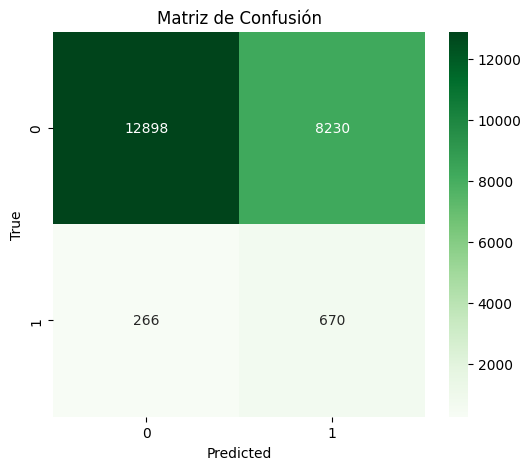

              precision    recall  f1-score   support

           0       0.98      0.61      0.75     21128
           1       0.08      0.72      0.14       936

    accuracy                           0.61     22064
   macro avg       0.53      0.66      0.44     22064
weighted avg       0.94      0.61      0.73     22064



In [ ]:
#@title Matriz de confusión
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Obtener predicciones en modo clase
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# 2. Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# 3. (Opcional) Mostrar matriz de confusión con heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

# 4. (Opcional) Informe detallado de clasificación
print(classification_report(y_test, y_pred))


In [ ]:
print(np.bincount(y_test))

[21128   936]


# SMOTE

In [ ]:
#@title Aplicación de SMOTE
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE # Importar SMOTE
from sklearn.metrics import confusion_matrix, classification_report # Para evaluar mejor

# --- APLICACIÓN DE SMOTE ---
print("Forma de X_train antes de SMOTE:", X_train.shape)
print("Forma de y_train antes de SMOTE:", y_train.shape)
print("Distribución de clases en y_train antes de SMOTE:\n", y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nForma de X_train después de SMOTE:", X_train_resampled.shape)
print("Forma de y_train después de SMOTE:", y_train_resampled.shape)
print("Distribución de clases en y_train después de SMOTE:\n", y_train_resampled.value_counts())
# --- FIN DE APLICACIÓN DE SMOTE ---

unique_values = len(np.unique(y_train_resampled)) # Usa y_train_resampled para el número de clases

Forma de X_train antes de SMOTE: (198568, 12)
Forma de y_train antes de SMOTE: (198568,)
Distribución de clases en y_train antes de SMOTE:
 Lung_Cancer_Diagnosis
0    190543
1      8025
Name: count, dtype: int64

Forma de X_train después de SMOTE: (381086, 12)
Forma de y_train después de SMOTE: (381086,)
Distribución de clases en y_train después de SMOTE:
 Lung_Cancer_Diagnosis
0    190543
1    190543
Name: count, dtype: int64


In [ ]:
#@title Entrenamiento con SMOTE
# Definición del modelo (tu arquitectura actual)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)), # Usa X_train_resampled para input_shape
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(unique_values, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento
# Con SMOTE, generalmente no necesitas class_weights. Si el modelo sigue sesgado,
# puedes probar con pesos pequeños, pero la idea es que SMOTE ya equilibró las clases.
# Eliminar o comentar la línea de class_weights por ahora para ver el efecto de SMOTE puro.
# class_weights = {0: 1, 1: 2} # Descomentar y ajustar si es necesario después de SMOTE
model.fit(X_train_resampled, y_train_resampled, epochs=12, verbose=1) #, class_weight=class_weights) # Usa datos re-muestreados

# Evaluación en test (siempre con los datos de prueba originales)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

# --- Obtener predicciones y matriz de confusión para análisis detallado ---
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) # Obtener la clase predicha (0 o 1)

print("\nMatriz de Confusión en el conjunto de prueba:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - accuracy: 0.6561 - loss: 0.6373
Epoch 2/12
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.6759 - loss: 0.6073
Epoch 3/12
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6970 - loss: 0.5771
Epoch 4/12
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7165 - loss: 0.5511
Epoch 5/12
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7341 - loss: 0.5252
Epoch 6/12
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.7461 - loss: 0.5061
Epoch 7/12
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7564 - loss: 0.4905
Epoch 8/12
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7661 - loss: 0.4752
Epoch 9/12
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.7726 - loss: 0.4646
Epoch 10/12
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.7808 - loss: 0.4519
Epoch 11/12
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7867 - loss: 0.44

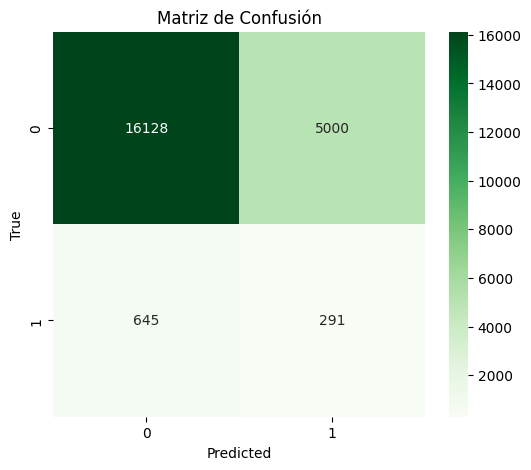

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# 3. (Opcional) Mostrar matriz de confusión con heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
#@title Balanceo de umbrales
y_pred_probs = model.predict(X_test)
# Para una clasificación binaria, nos interesa la probabilidad de la clase positiva (Clase 1)
y_pred_proba_class_1 = y_pred_probs[:, 1]

print("\n--- Evaluación con Ajuste de Umbral de Decisión ---")

# 2. Define un rango de umbrales para probar
# Puedes ajustar este rango y el paso según tus necesidades
thresholds = np.arange(0.05, 0.51, 0.05) # Prueba desde 0.05 hasta 0.50 en pasos de 0.05

best_f1_class_1 = -1
best_threshold = -1
best_recall_class_1 = -1 # También puedes querer rastrear el mejor recall

# 3. Itera a través de los umbrales
for threshold in thresholds:
    # Convertir probabilidades a predicciones binarias usando el umbral actual
    y_pred_threshold = (y_pred_proba_class_1 >= threshold).astype(int)

    # Calcular métricas para la clase 1 (clase positiva)
    current_precision_1 = precision_score(y_test, y_pred_threshold, pos_label=1, zero_division=0)
    current_recall_1 = recall_score(y_test, y_pred_threshold, pos_label=1, zero_division=0)
    current_f1_1 = f1_score(y_test, y_pred_threshold, pos_label=1, zero_division=0)

    print(f"\n--- Umbral: {threshold:.2f} ---")
    print(confusion_matrix(y_test, y_pred_threshold))
    print(classification_report(y_test, y_pred_threshold, zero_division=0))

    # Opcional: Guardar el mejor umbral basado en una métrica (ej. F1-Score para Clase 1)
    if current_f1_1 > best_f1_class_1:
        best_f1_class_1 = current_f1_1
        best_threshold = threshold
    # Si priorizas Recall de Clase 1, podrías hacer:
    # if current_recall_1 > best_recall_class_1:
    #     best_recall_class_1 = current_recall_1
    #     best_threshold_for_recall = threshold


print(f"\n--- Resultados Resumidos ---")
print(f"El mejor F1-Score para la Clase 1 encontrado fue {best_f1_class_1:.4f} con un umbral de {best_threshold:.2f}")

690/690 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

--- Evaluación con Ajuste de Umbral de Decisión ---

--- Umbral: 0.05 ---
[[ 5203 15925]
 [  209   727]]
              precision    recall  f1-score   support

           0       0.96      0.25      0.39     21128
           1       0.04      0.78      0.08       936

    accuracy                           0.27     22064
   macro avg       0.50      0.51      0.24     22064
weighted avg       0.92      0.27      0.38     22064


--- Umbral: 0.10 ---
[[ 6958 14170]
 [  272   664]]
              precision    recall  f1-score   support

           0       0.96      0.33      0.49     21128
           1       0.04      0.71      0.08       936

    accuracy                           0.35     22064
   macro avg       0.50      0.52      0.29     22064
weighted avg       0.92      0.35      0.47     22064


--- Umbral: 0.15 ---
[[ 8455 12673]
 [  329   607]]
              precision    recall  f1-score   support

           0       0.96      0.40     

# Random Forest + SMOTE

In [ ]:
#@title Definición y entrenamiento
random_state = 42

# Creamos el Random Forest Classifier con valores de ejemplo.
# Puedes ajustar n_estimators, max_depth, min_samples_split, etc. en función de tu problema.
rfc = RandomForestClassifier(
    n_estimators=200,        # Número de árboles en el ensamble
    max_depth=None,          # Profundidad máxima de cada árbol (None → sin límite)
    min_samples_split=5,     # Mínimo de muestras requerido para dividir un nodo
    min_samples_leaf=1,      # Mínimo de muestras en cada hoja
    max_features="sqrt",     # Número de características a considerar cuando se busca la mejor separación
    random_state=random_state,
    n_jobs=-1                # Utilizar todos los núcleos disponibles para acelerar el entrenamiento
)

# Usamos X_train_resampled y y_train_resampled que ya están balanceados
rfc.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(min_samples_split=5, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [ ]:
#@title Resultado

y_pred = rfc.predict(X_test)
y_proba = rfc.predict_proba(X_test)[:, 1]  # Probabilidad de clase "1" (patrón positivo)

acc = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred, target_names=["No-Cáncer", "Cáncer"])

print("=== Métricas de validación ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}\n")

print("=== Matriz de Confusión ===")
print(cm)
print("\n=== Reporte de Clasificación ===")
print(report)


=== Métricas de validación ===
Accuracy : 0.9290
Precision: 0.0408
Recall   : 0.0299
F1-score : 0.0345
ROC-AUC  : 0.4994

=== Matriz de Confusión ===
[[20470   658]
 [  908    28]]

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

   No-Cáncer       0.96      0.97      0.96     21128
      Cáncer       0.04      0.03      0.03       936

    accuracy                           0.93     22064
   macro avg       0.50      0.50      0.50     22064
weighted avg       0.92      0.93      0.92     22064



# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Entrenar el árbol de decisión
dt = DecisionTreeClassifier(random_state=42, min_samples_split=20, min_samples_leaf=10,criterion='entropy', max_depth=5)  # Puedes ajustar max_depth
dt.fit(X_train_resampled, y_train_resampled)

# Predicciones en el conjunto de prueba
y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)[:, 1]

# Mostrar métricas
print("🔎 Decision Tree con SMOTE")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_dt):.4f}")

# Visualizar matriz de confusión
disp = ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)
disp.ax_.set_title("Matriz de Confusión - Decision Tree")
disp.plot()

# Visualizar curva ROC
RocCurveDisplay.from_estimator(dt, X_test, y_test)
plt.show()

# Visualizar el árbol
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X.columns, class_names=['No', 'Yes'], filled=True, rounded=True)
plt.title("Árbol de Decisión")
plt.show()


# Clustering

Número de características después de PCA: 8
Varianza explicada por los 8 componentes principales: 0.8222

Distribución de clases en y_train antes de SMOTE:
 Lung_Cancer_Diagnosis
0    190543
1      8025
Name: count, dtype: int64

Distribución de clases en y_train después de SMOTE:
 Lung_Cancer_Diagnosis
0    190543
1    190543
Name: count, dtype: int64

--- Entrenamiento del modelo con datos PCA y resampleados por SMOTE ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.6531 - loss: 0.6454
Epoch 2/7
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.6608 - loss: 0.6302
Epoch 3/7
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.6701 - loss: 0.6153
Epoch 4/7
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.6814 - loss: 0.5970
Epoch 5/7
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.6918 - loss: 0.5819
Epoch 6/7
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.7014 - loss: 0.5668
Epoch 7/7
11909/11909 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.7121 - loss: 0.5535

Test Loss: 0.5935
Test Accuracy: 0.6411
690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Matriz de Confusión en el conjunto de prueba:
[[13615  7513]
 [  406   530]]


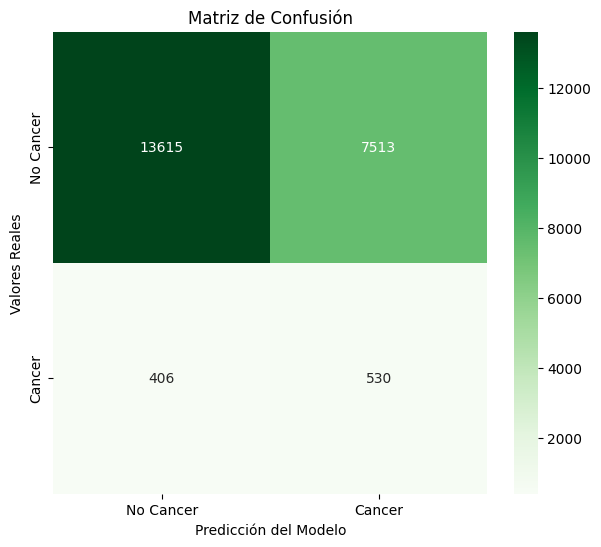

In [ ]:
#@title PCA + SMOTE + Red
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # Importar PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

num_cols = X.columns.tolist() # Escalar todas las columnas si son todas numéricas


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

pca = PCA(n_components=8, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Número de características después de PCA: {X_train_pca.shape[1]}")
print(f"Varianza explicada por los 8 componentes principales: {pca.explained_variance_ratio_.sum():.4f}")

# --- 3. Aplicación de SMOTE (opcional, después de PCA) ---
print("\nDistribución de clases en y_train antes de SMOTE:\n", y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

print("\nDistribución de clases en y_train después de SMOTE:\n", y_train_resampled.value_counts())
# --- FIN DE APLICACIÓN DE SMOTE ---


# --- 4. Definición y Entrenamiento de la Red Neuronal ---

unique_values = len(np.unique(y_train_resampled))

# La capa de entrada de la red neuronal debe coincidir con el número de componentes de PCA
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(unique_values, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Entrenamiento del modelo con datos PCA y resampleados por SMOTE ---")
# Entrenar con los datos reducidos por PCA y potencialmente resampleados por SMOTE
history = model.fit(X_train_resampled, y_train_resampled, epochs=7, verbose=1)

# --- 5. Evaluación en el conjunto de prueba ---
test_loss, test_acc = model.evaluate(X_test_pca, y_test, verbose=0) # Usar X_test_pca
print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

# --- 6. Obtener predicciones y generar la matriz de confusión ---
y_pred_probs = model.predict(X_test_pca) # Predecir con X_test_pca
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nMatriz de Confusión en el conjunto de prueba:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

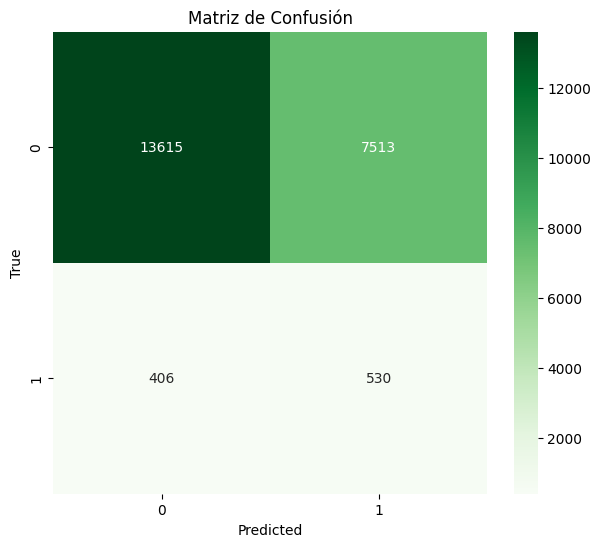

In [ ]:
# Plotting the confusion matrix with heatmap
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()